In [2]:

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, _safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
# import missingpy as missingpy
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy import stats

# Set folder paths for outputs

In [3]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'forest 26')

In [4]:
os.chdir('..')
PATH_1 = Path(os.getcwd())
os.chdir('..')
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier')

In [5]:
from Mixed_Distances.distMix import distmix
from scipy.spatial.distance import cdist
from Sampling_Methods.Balance import BalanceDataset
from Sampling_Methods.Sampling_Study.auxSamplingStudy import *

In [6]:
os.chdir(PATH_1)
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier/Sampling_Methods')

# Read the file

In [7]:
df = pd.read_csv(DATA / 'covtype.data.gz', compression='gzip', header=None, sep=',', quotechar='"', error_bad_lines=False)

In [8]:
df.head()

0    1   2    3    4     5    6    7    8     9   ...  45  46  47  48  \
0  2596   51   3  258    0   510  221  232  148  6279  ...   0   0   0   0   
1  2590   56   2  212   -6   390  220  235  151  6225  ...   0   0   0   0   
2  2804  139   9  268   65  3180  234  238  135  6121  ...   0   0   0   0   
3  2785  155  18  242  118  3090  238  238  122  6211  ...   0   0   0   0   
4  2595   45   2  153   -1   391  220  234  150  6172  ...   0   0   0   0   

   49  50  51  52  53  54  
0   0   0   0   0   0   5  
1   0   0   0   0   0   5  
2   0   0   0   0   0   2  
3   0   0   0   0   0   2  
4   0   0   0   0   0   5  

[5 rows x 55 columns]

# The raw data is one-hot encoded. We reverse encoded the data, to have categorical features back

### Prepare categorical column 'Wilderness_Area' from encoded column 10,11, 12 and 13

In [9]:
df['Wilderness_Area'] = 999

In [10]:
is_10_1 = df.iloc[:, 10] == 1
is_11_1 = df.iloc[:, 11] == 1
is_12_1 = df.iloc[:, 12] == 1
is_13_1 = df.iloc[:, 13] == 1

In [11]:
df.loc[is_10_1, 'Wilderness_Area'] = 0
df.loc[is_11_1, 'Wilderness_Area'] = 1
df.loc[is_12_1, 'Wilderness_Area'] = 2
df.loc[is_13_1, 'Wilderness_Area'] = 3

# Prepare categorical column 'Soil_Type' from encoded column 14 to 53

In [12]:
Soil_Type_df = df.iloc[:, 14:54]

In [13]:
def get_level(row):
    for c in Soil_Type_df.columns:
        if row[c]==1:
            return c - 14
        
df['Soil_Type'] = df.apply(get_level, axis=1)

In [14]:
Counter(df.Wilderness_Area)

Counter({0: 260796, 2: 253364, 3: 36968, 1: 29884})

In [15]:
columns_selected = [i for i in range(10)]

In [16]:
columns_selected.extend(('Wilderness_Area', 'Soil_Type', 54))

In [17]:
df = df[columns_selected]

In [18]:
df.columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
             'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
              'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type', 'Cover_Type']


In [19]:
anovap_value = list()
for cols in ['Soil_Type', 'Wilderness_Area']:
    statistic, p = stats.f_oneway(df[cols], df['Cover_Type'])
    anovap_value.append(tuple([cols, p]))
    
print(anovap_value)

[('Soil_Type', 0.0), ('Wilderness_Area', 0.0)]


In [20]:
from scipy.stats import chi2_contingency
chi2p_value = list()
for cols in ['Soil_Type', 'Wilderness_Area']:
    obs = pd.crosstab(df[cols], df['Cover_Type'])
    g, p, dof, expctd = chi2_contingency(obs)
    chi2p_value.append(tuple([cols, p]))
    
print(chi2p_value)

[('Soil_Type', 0.0), ('Wilderness_Area', 0.0)]


In [21]:
df.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  Wilderness_Area  Soil_Type  Cover_Type  
0                                6279                0         28           5  
1                                6225                0         28           5  
2                                6121                0         11           2  
3                                6211                0         29           2  
4                                6172                0         28           5

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.shape

(581012, 13)

In [24]:
df.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area                       0
Soil_Type                             0
Cover_Type                            0
dtype: int64

In [25]:
Counter(df.Cover_Type)

Counter({5: 9493, 2: 283301, 1: 211840, 7: 20510, 3: 35754, 6: 17367, 4: 2747})

### There are 7 target labels of the dataset- 2 and 6 are randomly chosen among them(since this algorithm is built for binary classification)

In [26]:
df = df.loc[df['Cover_Type'].isin([2, 6])]
df['Cover_Type'].replace({2: 0, 6: 1},inplace = True)

In [27]:
len(df.Soil_Type.unique())

39

In [28]:
Counter(df.Cover_Type)

Counter({0: 283301, 1: 17367})

In [29]:
df_feature= df.drop('Cover_Type',1)
df_target= df[['Cover_Type']]
df_target = df_target.rename(columns={'Cover_Type': 'target'})
df_feature.index = pd.RangeIndex(len(df_feature.index))
df_target.index = pd.RangeIndex(len(df_target.index))

In [30]:
col_list = list(df_feature.columns)

In [31]:
df_feature.shape

(300668, 12)

In [32]:
test_size = 1 - 2000 / df_feature.shape[0]

In [33]:
np.sum(df_target)/df_target.shape[0]

target    0.057761
dtype: float64

In [34]:
#Sampling: Added by me
df_feature, aux1, df_target, aux2 = train_test_split(df_feature, df_target, test_size=test_size, random_state=12)

In [35]:
df_feature.shape


(2000, 12)

In [36]:
np.sum(df_target)

target    130
dtype: int64

In [37]:
np.sum(df_target)/df_target.shape[0]


target    0.065
dtype: float64

In [38]:
1/16

0.0625

In [39]:
# Split the raw data into train and test set. Split ratio = 75:25

X_train, X_test, y_train, y_test = train_test_split(df_feature, df_target, test_size=0.25, random_state=12)

In [40]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [41]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased

columns = [0,1,2,3,4,5,6,7,8,9]
name_columns = X_train.columns[columns]

sc = StandardScaler()
X_train[name_columns] = sc.fit_transform(X_train[name_columns])
X_test[name_columns] = sc.transform(X_test[name_columns])

In [42]:
X_train.shape

(1500, 12)

In [43]:
nbinsA = calculate_nbins(X_train, [10, 11], "average")
nbinsFD = calculate_nbins(X_train, [0,1,2,3,4,5,6,7,8,9], "FD")
print(nbinsA)
print(nbinsFD)

[4, 33]
[30.573882655031277, 10.403858558902433, 27.981903706859228, 24.07701543377857, 58.04318690457143, 17.64221770902621, 30.296196494644562, 30.048748867024962, 28.732327488088625, 24.828961638001818]
18
28


# Create helper functions

In [44]:
## Split the data to be 2-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#randomforest model - hyperparameter tuning using grid search
param_grid = {
'max_depth': [7,11], 'max_features': [3,6],
'min_samples_leaf': [3], 'min_samples_split': [3], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}


In [44]:
## Apply the random-forest classifier along with the NEW SMOTE-ENC method

filename = (MODELS / 'forest_mysmotenc_26.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [10, 11]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = 1, verbose = 2)
grid_search.fit(df_feature, df_target)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   2.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   2

In [45]:
## Apply the random-forest classifier along with the exsting SMOTE-NC method

filename = (MODELS / 'forest_smotenc_26.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [10, 11]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(df_feature, df_target)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.9s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.9s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.8s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=6, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.8s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=6, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.8s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=6, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   4.2s
[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   4.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   4.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=6, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=6, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.7s
[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   4.2s
[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__max_features=3, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   4.2s
[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__max_features=6, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.9s
[CV] END randomforestclassifier__max_depth=11, random

In [46]:
dict_methods = {"gower": {"method": "gower", "weigths_boolean": False, "nbins":3},
                "huang": {"method": "huang", "weigths_boolean": False, "nbins":3},
                "ahmadA": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadFD": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsFD},
                "ahmadMahA": {"method": "ahmad_mahalanobis", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadMahFD": {"method": "ahmad_mahalanobis", "weigths_boolean": True, "nbins":nbinsFD},
                "ahmadL1A": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadL1FD": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsFD}
                }  

methods_saved = []

for name, dict_info in dict_methods.items():

    filename = (MODELS / f'forest_rsmotenc_{name}_26.sav')
    samp_pipeline = make_pipeline(BalanceDataset(cat_vars = X_train.columns[[10,11]], method=dict_info["method"], weigths_boolean = dict_info["weigths_boolean"], nbins=dict_info["nbins"]), 
                                RandomForestClassifier(random_state=42))
    # check model performance on different values of hyper-parameters.
    grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                            return_train_score=True, n_jobs = 1, verbose = 2)
    grid_search.fit(X_train, y_train)
    best_grid = grid_search.best_estimator_
    pickle.dump(best_grid, open(filename, 'wb'))

    methods_saved.append(name)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
(1200, 12)
(78, 12)
[[0.         0.2844804  0.26901226 ... 0.37719456 0.39477244 0.38539501]
 [0.2844804  0.         0.19084133 ... 0.36668995 0.34080873 0.37113159]
 [0.26901226 0.19084133 0.         ... 0.40286233 0.38491389 0.41057729]
 ...
 [0.37719456 0.36668995 0.40286233 ... 0.         0.26455146 0.13943996]
 [0.39477244 0.34080873 0.38491389 ... 0.26455146 0.         0.20129649]
 [0.38539501 0.37113159 0.41057729 ... 0.1

In [44]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'forest_smotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

                RF performance Report
Best Threshold:  0.5
Predicted  False  True
Actual                
0           1198   205
1              7    90
              precision    recall  f1-score   support

           0     0.9942    0.8539    0.9187      1403
           1     0.3051    0.9278    0.4592        97

    accuracy                         0.8587      1500
   macro avg     0.6496    0.8909    0.6889      1500
weighted avg     0.9496    0.8587    0.8890      1500

Best Threshold:  0.5
Predicted  False  True
Actual                
0            411    56
1              1    32
              precision    recall  f1-score   support

           0     0.9976    0.8801    0.9352       467
           1     0.3636    0.9697    0.5289        33

    accuracy                         0.8860       500
   macro avg     0.6806    0.9249    0.7320       500
weighted avg     0.9557    0.8860    0.9083       500



In [57]:
## Evaluate SMOTE-NC performance on train and test set
filename = (MODELS / 'forest_mysmotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

                RF performance Report
Best Threshold:  0.5
Predicted  False  True
Actual                
0            929   474
1              3    94
              precision    recall  f1-score   support

           0     0.9968    0.6622    0.7957      1403
           1     0.1655    0.9691    0.2827        97

    accuracy                         0.6820      1500
   macro avg     0.5811    0.8156    0.5392      1500
weighted avg     0.9430    0.6820    0.7625      1500

Best Threshold:  0.5
Predicted  False  True
Actual                
0            307   160
1              0    33
              precision    recall  f1-score   support

           0     1.0000    0.6574    0.7933       467
           1     0.1710    1.0000    0.2920        33

    accuracy                         0.6800       500
   macro avg     0.5855    0.8287    0.5427       500
weighted avg     0.9453    0.6800    0.7602       500



In [45]:
filename = (MODELS / 'forest_rsmotenc_ahmadL110_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

                RF performance Report
Best Threshold:  0.35000000000000003
Predicted  False  True
Actual                
0           1386    17
1             10    87
              precision    recall  f1-score   support

           0     0.9928    0.9879    0.9904      1403
           1     0.8365    0.8969    0.8657        97

    accuracy                         0.9820      1500
   macro avg     0.9147    0.9424    0.9280      1500
weighted avg     0.9827    0.9820    0.9823      1500

Best Threshold:  0.45
Predicted  False  True
Actual                
0            467     0
1              8    25
              precision    recall  f1-score   support

           0     0.9832    1.0000    0.9915       467
           1     1.0000    0.7576    0.8621        33

    accuracy                         0.9840       500
   macro avg     0.9916    0.8788    0.9268       500
weighted avg     0.9843    0.9840    0.9830       500



In [78]:
filename = (MODELS / 'forest_rsmotenc_AhmadL1A_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')

#best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model, "f1ScoreIR")
#print("Best Threshold: ", best_threshold)
#evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model, "f1ScoreRecallIR")
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.05
Confusion Matrix : 
 [[ 32  53]
 [  1 414]]
Accuracy :  0.892
F1-Score IR :  0.569
F1-Score Recall IR :  0.964
Class 1
Precision :  0.376
Sensitivity :  0.97
F1-Score :  0.542
Class 0
Precision :  0.998
Sensitivity :  0.887
F1-Score :  0.939


array([0.35544531, 0.01918925, 0.02912031, 0.02082006, 0.00727368,
       0.08358944, 0.0425566 , 0.02226592, 0.01026778, 0.07683579,
       0.03961544, 0.29302042])

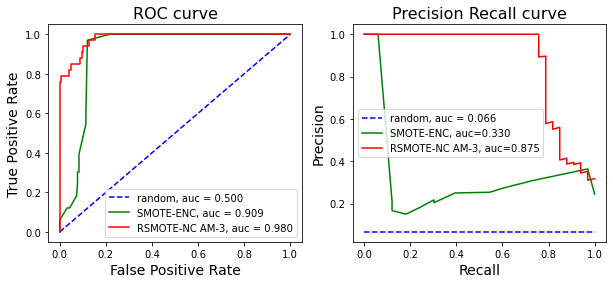

In [47]:
##Create ROC-AUC and PR-AUC curve

dict_models = {"SMOTE-ENC": MODELS / 'forest_smotenc_26.sav',
                "RSMOTE-NC AM-3": MODELS / 'forest_rsmotenc_ahmadL110_26.sav'}

#generate_curves(dict_models, X_test, y_test,save = REPORTS / "forest26_roc_prc.jpeg")
generate_curves(dict_models, X_test, y_test)

<Figure size 720x720 with 0 Axes>

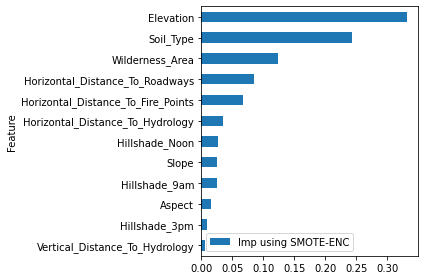

In [39]:
## Find out top 4 most important features using our new SMOTE-ENC method
filename = (MODELS / 'forest_mysmotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=df_feature.columns).nlargest(15))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'forest26_mysmotenc_26.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

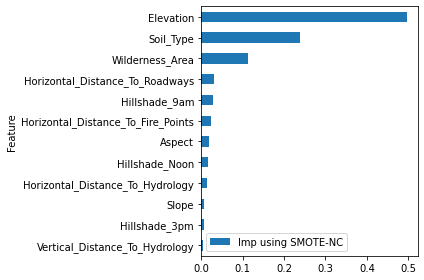

In [40]:
## Find out top 4 most important features using existing SMOTE-NC method
filename = (MODELS / 'forest_smotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=df_feature.columns).nlargest(15))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-NC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'forest26_smotenc_26.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

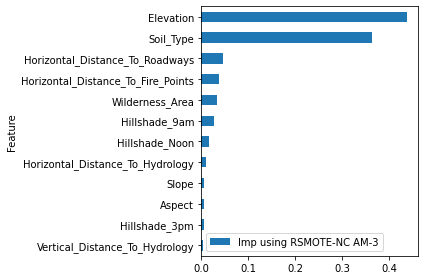

In [42]:
filename = (MODELS / 'forest_rsmotenc_ahmadMah3_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=df_feature.columns).nlargest(15))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using RSMOTE-NC AM-3']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'forest_rsmotenc_ahmadMah3_26.jpeg', bbox_inches='tight')

In [41]:
filename = (MODELS / 'forest_mysmotenc_26.sav')
model1 = pickle.load(open(filename, 'rb'))

filename = (MODELS / 'forest_smotenc_26.sav')
model2 = pickle.load(open(filename, 'rb'))

for scoring in ('precision', 'precision_micro', 'precision_macro', 'precision_weighted',
                'f1', 'f1_micro', 'f1_macro', 'f1_weighted', 
                'recall', 'recall_macro', 'recall_micro', 'recall_weighted'):
    
    cv_scoremodel1 = cross_val_score(model1, df_feature, df_target, cv=kfold, scoring = scoring)
    cv_scoremodel2 = cross_val_score(model2, df_feature, df_target, cv=kfold, scoring = scoring)
    t, p = stats.ttest_ind(cv_scoremodel1, cv_scoremodel2, equal_var = True)
    print(scoring, t, p)
    

In [41]:
idnum = [0,1,2,3,4,5,6,7,8,9]
idbin = []
idcat = [10,11]

data = df_feature.to_numpy()

distance_matrices = {"Euclidean": cdist(data.astype(np.float16),data.astype(np.float16)),
                    "Gower" : distmix(data, method = "gower", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Huang" : distmix(data, method = "huang", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 3": distmix(data, method = "ahmad", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 10": distmix(data, method = "ahmad", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 3" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 10" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat )}

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  2.7151689529418945
Cat finished
---------------------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]
[10, 11]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  2.6667559146881104
Cat finished


In [40]:
np.sum(df_target)

target    130
dtype: int64

0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 

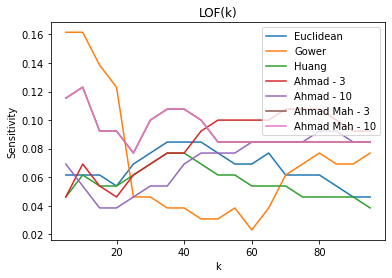

0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 

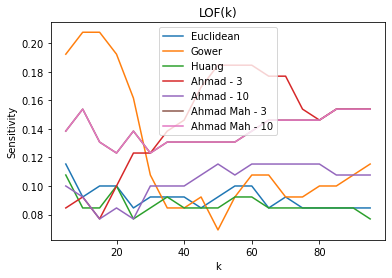

0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 120592,  88400,  81696, 263578,
            225021, 175296,
            ...
            114565, 122929, 196886,  61872, 208716, 206083,  36482,  40177,
            255366, 235163],
           dtype='int64', length=2000)
0
RangeIndex(start=0, stop=2000, step=1)
Int64Index([176527, 250718,  98841, 264603, 

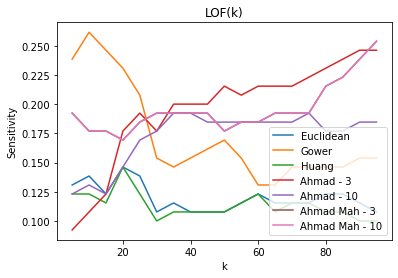

In [42]:
outlier_prevelance = 130
index = df_feature.index
neigbs = list(range(5,100,5))
metric = "Sensitivity"

test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance, metric, save = REPORTS / "forest26_distances100.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, int(outlier_prevelance*1.5), metric, save = REPORTS / "forest26_distances150.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance*2, metric, save = REPORTS / "forest26_distances200.jpeg")